    Author(s): Daniel Tweneboah Anyimadu, Taofik Ahmed Suleiman

# CADx PROJECT: SKIN LESION CLASSIFICATION CHALLENGE USING DEEP LEARNING APPROACH

- A deep learning (DL) approach is employed to address both two-class and three-class problems, improving classification accuracy despite huge class imbalances and lesion variations.

- NB: This code is for the two (2) class problem: nevus, others.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORT LIBRARIES (MODULES)

In [33]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from glob import glob
from PIL import Image
import random
from tqdm import tqdm
from sklearn.utils import shuffle

# Libraries for data preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize


# Libraries for feature extraction/classification using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# Libraries for evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [34]:
from zipfile import ZipFile
import os
from tqdm.notebook import tqdm
import numpy as np
import io

# FUNCTIONS FOR PREPROCESSING

In [35]:
def vignette_removal(image: np.ndarray, threshold: int = 50):
    '''
    Automatically crop the image to preserve the main content and eliminate any vignette.
    This process entails evaluating pixel values along the diagonal of the image.

    Args:
    - image (numpy ndarray): The input image to be cropped.
    - threshold (int): The threshold value to differentiate between the image and the vignette.

    Returns:
    - The coordinates of the cropping rectangle and the cropped image.
    '''
    # Find image dimensions
    height, width = image.shape[:2]
    greatest_common_divisor = np.gcd(height, width)

    # Calculate diagonal pixel coordinates
    y_coords = ([i for i in range(0, height, int(height / greatest_common_divisor))], [i for i in range(height - int(height / greatest_common_divisor), 0, -int(height / greatest_common_divisor))])
    x_coords = ([i for i in range(0, width, int(width / greatest_common_divisor))], [i for i in range(0, width, int(width / greatest_common_divisor))])

    # Compute mean pixel values along the diagonal
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': height, 'x2_1': width, 'y1_2': height, 'x1_2': 0, 'y2_2': 0, 'x2_2': width}
    for i in range(2):
        diagonal_values = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = height, width
        for y, x in zip(y_coords[i], x_coords[i]):
            diagonal_values.append(np.mean(image[y, x, :]))

        # Determine the location of the first point where the threshold is crossed
        for idx, value in enumerate(diagonal_values):
            if value >= threshold and idx != 0:  # In the absence of a vignette, the value would be above the threshold at idx=0
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Find the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(diagonal_values)):
            if value >= threshold and idx != 0:  # In the absence of a vignette, the value would be above the threshold at idx=0
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i]) - idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i]) - idx]
                break

    # Define the coordinates for cropping the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    cropped_image = image[y1:y2, x1:x2, :]

    if cropped_image.shape[0] == 0 or cropped_image.shape[1] == 0:
        cropped_image = image

    return cropped_image

# Define the target size for resizing
target_size = (256, 256)
# Function to load and resize images
def load_and_resize_image(file_path):
    img = Image.open(io.BytesIO(file_path))
    img = img.resize(target_size)
    return img

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling dataset:**

    Training

In [36]:
# Zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/binarycollab.zip'

# Initialize lists to store all the extracted data
tr_image_names = []; tr_image_files = []; tr_gtruth_names = []; tr_gtruth = [];
preprocessed_imgs = []

# Image directories within the zip file
tr_nevus = "binarycollab/train/nevus"
tr_others = "binarycollab/train/others"

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    valid_nevus_images = [f for f in zip_ref.namelist() if f.startswith(tr_nevus) and zip_ref.read(f)]
    # Process all images in the "nevus" folder
    for nevus_img in tqdm(valid_nevus_images, desc="Nevus"):
      img_content = zip_ref.read(nevus_img)

    # Check if the content is not empty
      if img_content:
        try:

            # For nevus images (groundtruth = 0)
            resized_images = np.array(load_and_resize_image(img_content))
            cropped_img = vignette_removal(resized_images, threshold=50)
            preprocessed_imgs.append(cropped_img)
            tr_image_names.append(nevus_img)
            tr_image_files.append(os.path.join(tr_nevus, nevus_img))
            tr_gtruth_names.append("nevus")
            tr_gtruth.append(0)

        except Exception as e:
            print(f"Error processing image {nevus_img}: {e}")
      else:
        print(f"Empty content for image {nevus_img}")

    # Process all images in the "others" folder
    valid_others_images = [f for f in zip_ref.namelist() if f.startswith(tr_others) and zip_ref.read(f)]
    for others_img in tqdm(valid_others_images, desc="Others"):
      img_content = zip_ref.read(others_img)

      if img_content:
        try:
            resized_images = np.array(load_and_resize_image(img_content))
            cropped_img = vignette_removal(resized_images, threshold=50)
            preprocessed_imgs.append(cropped_img)
            tr_image_names.append(others_img)
            tr_image_files.append(os.path.join(tr_others, others_img))
            tr_gtruth_names.append("others")
            tr_gtruth.append(1)
        except Exception as e:
            print(f"Error processing image {others_img}: {e}")
      else:
        print(f"Empty content for image {others_img}")

Nevus:   0%|          | 0/7725 [00:00<?, ?it/s]

Others:   0%|          | 0/7470 [00:00<?, ?it/s]

In [37]:
# Training dataframe
tr_data = {"tr_img_name": tr_image_names, "tr_img_file": tr_image_files, "preprocessed_images": preprocessed_imgs, "tr_gtruth_name": tr_gtruth_names,"tr_gtruth": tr_gtruth}; tr_image_names.sort()
tr_df = pd.DataFrame(tr_data)
tr_df.head()

,tr_img_name,tr_img_file,preprocessed_images,tr_gtruth_name,tr_gtruth
0,binarycollab/train/nevus/nev00001.jpg,binarycollab/train/nevus/binarycollab/train/ne...,"[[[150, 114, 135], [147, 114, 133], [148, 114,...",nevus,0
1,binarycollab/train/nevus/nev00002.jpg,binarycollab/train/nevus/binarycollab/train/ne...,"[[[90, 78, 81], [108, 101, 104], [125, 120, 12...",nevus,0
2,binarycollab/train/nevus/nev00003.jpg,binarycollab/train/nevus/binarycollab/train/ne...,"[[[85, 81, 70], [89, 85, 72], [92, 89, 74], [9...",nevus,0
3,binarycollab/train/nevus/nev00004.jpg,binarycollab/train/nevus/binarycollab/train/ne...,"[[[182, 177, 182], [181, 176, 179], [184, 176,...",nevus,0
4,binarycollab/train/nevus/nev00005.jpg,binarycollab/train/nevus/binarycollab/train/ne...,"[[[206, 145, 159], [206, 144, 161], [204, 141,...",nevus,0


    Visualization of training data

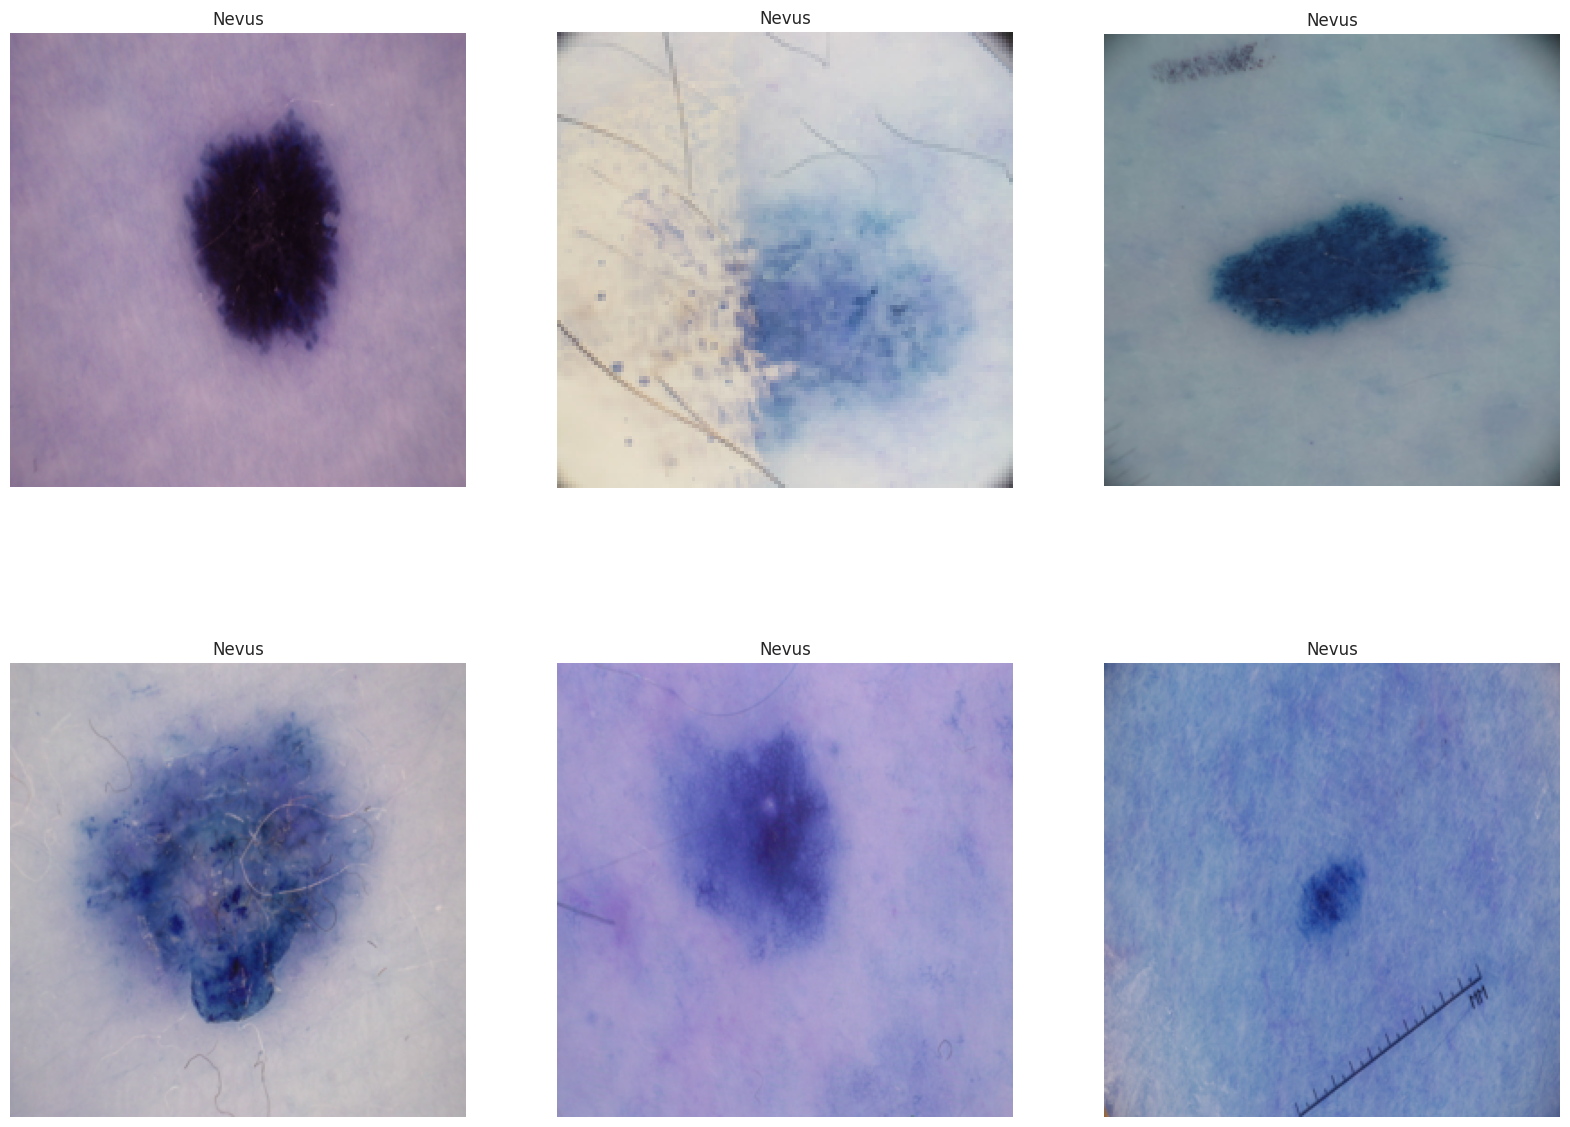

In [38]:
sns.set_style("white")

plt.figure(figsize = [20, 15])
for i, (image_data, ground_truth) in enumerate(zip(tr_df["preprocessed_images"][:6], tr_df["tr_gtruth"][:6])):
    title = "Nevus" if ground_truth == 0 else "Others"     # Set the title based on ground truth

    plt.subplot(2, 3, i + 1)                               # Plot the image
    plt.imshow(cv.cvtColor(image_data, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis("off"); plt.title(title)

plt.show()

    Validation

In [39]:
val_image_names = []
val_image_files = []
val_preprocessed_imgs = []
val_gtruth = []
val_gtruth_names = []

# Paths to the image directories within the zip file
val_nevus = "binarycollab/val/nevus"
val_others = "binarycollab/val/others"

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    val_valid_nevus_images = [f for f in zip_ref.namelist() if f.startswith(val_nevus) and zip_ref.read(f)]
    for val_nevus_img in tqdm(val_valid_nevus_images, desc="Nevus"):
      val_img_content = zip_ref.read(val_nevus_img)

    # Check if the validation content is not empty
      if val_img_content:
        try:
            val_resized_images = np.array(load_and_resize_image(val_img_content))
            val_cropped_img = vignette_removal(val_resized_images, threshold=50)
            val_preprocessed_imgs.append(val_cropped_img)
            val_image_names.append(val_nevus_img)
            val_image_files.append(os.path.join(val_nevus, val_nevus_img))
            val_gtruth_names.append("nevus")
            val_gtruth.append(0)
        except Exception as e:
            print(f"Error processing image {val_nevus_img}: {e}")
      else:
        print(f"Empty content for image {val_nevus_img}")

    # Process all images in the "val others" folder
    val_valid_others_images = [f for f in zip_ref.namelist() if f.startswith(val_others) and zip_ref.read(f)]
    for val_others_img in tqdm(val_valid_others_images, desc="Others"):
      val_img_content = zip_ref.read(val_others_img)

      if val_img_content:
        try:
            val_resized_images = np.array(load_and_resize_image(val_img_content))
            val_cropped_img = vignette_removal(val_resized_images, threshold=50)
            val_preprocessed_imgs.append(val_cropped_img)
            val_image_names.append(val_others_img)
            val_image_files.append(os.path.join(val_others, val_others_img))
            val_gtruth_names.append("others")
            val_gtruth.append(1)
        except Exception as e:
            print(f"Error processing image {val_others_img}: {e}")
      else:
        print(f"Empty content for image {val_others_img}")

Nevus:   0%|          | 0/1931 [00:00<?, ?it/s]

Others:   0%|          | 0/1865 [00:00<?, ?it/s]

In [40]:
# Validation dataframe
val_data = {"val_img_name": val_image_names, "val_img_file": val_image_files, "val_preprocessed_images": val_preprocessed_imgs, "val_gtruth_name": val_gtruth_names, "val_gtruth": val_gtruth}; val_image_names.sort()
val_df = pd.DataFrame(val_data)
val_df.head()

,val_img_name,val_img_file,val_preprocessed_images,val_gtruth_name,val_gtruth
0,binarycollab/val/nevus/nev07726.jpg,binarycollab/val/nevus/binarycollab/val/nevus/...,"[[[74, 79, 82], [77, 82, 85], [82, 87, 90], [8...",nevus,0
1,binarycollab/val/nevus/nev07727.jpg,binarycollab/val/nevus/binarycollab/val/nevus/...,"[[[233, 144, 154], [232, 142, 153], [233, 144,...",nevus,0
2,binarycollab/val/nevus/nev07728.jpg,binarycollab/val/nevus/binarycollab/val/nevus/...,"[[[183, 192, 200], [186, 194, 201], [188, 197,...",nevus,0
3,binarycollab/val/nevus/nev07729.jpg,binarycollab/val/nevus/binarycollab/val/nevus/...,"[[[78, 83, 87], [85, 89, 92], [90, 94, 96], [9...",nevus,0
4,binarycollab/val/nevus/nev07730.jpg,binarycollab/val/nevus/binarycollab/val/nevus/...,"[[[231, 142, 158], [230, 142, 158], [229, 139,...",nevus,0


# DATA PREPROCESSING

**Data generation**
    
    Split the "tr_df" class-wise to maintain class distribution. Training = first 80%, Fake_Test = second 20%

In [41]:
# Convert the numPy arrays in the dataframe to lists
image_arrays = list(tr_df["preprocessed_images"])
labels = list(tr_df["tr_gtruth"])

# StratifiedShuffleSplit object for class-wise splitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, ftest_indices = next(sss.split(image_arrays, labels))

# Create dataframes for training and fake_test
train_df_split = tr_df.iloc[train_indices]
ftest_df_split = tr_df.iloc[ftest_indices]

In [42]:

# Data preprocessing (real-time augmentation) for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Data preprocessing for fake_test (validation)
ftest_datagen = ImageDataGenerator(rescale=1./255)

# Train and Val generator
batch_size = 64
target_shape = (224, 224, 3)
train_images = np.array([resize(image, target_shape) for image in train_df_split["preprocessed_images"].values])
train_labels = np.array(train_df_split["tr_gtruth"])

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=batch_size
)

ftest_images = np.array([resize(image, target_shape) for image in ftest_df_split["preprocessed_images"].values])
ftest_labels = np.array(ftest_df_split["tr_gtruth"])

# Flow validation images in batches using ftest_datagen generator
ftest_generator = ftest_datagen.flow(
    x=ftest_images,
    y=ftest_labels,
    batch_size=batch_size
)


**Compute class weight for unbalanced dataset**

In [43]:
class_labels = np.unique(train_df_split["tr_gtruth_name"])
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_df_split["tr_gtruth_name"])
class_weights_dict = dict(zip(range(len(class_labels)), class_weights))

# FEATURE EXTRACTION AND CLASSIFICATION

**Leveraging DL models for feature extraction and classification:**

**- Pre-trained model ()**

We have trained several models on the other notebook.This notebook contains only the training and ensembles of our best models

# **- Pre-trained model (ResNet50)**

Reference: https://github.com/Defcon27/Skin-Cancer-Classification-using-Transfer-Learning/blob/master/Skin%20Cancer%20Prediction%20ResNet50.ipynb

In [28]:
# Load pre-trained ResNet50 model with weights trained on ImageNet data
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = True

# Build the custom model using ResNet50 as a feature extractor
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=resnet_model.input, outputs=x)

# Compile the model
model_resnet.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

    Callbacks

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_resnet_E50.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 100, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 1.6139 - accuracy: 0.7554
Epoch 1: val_accuracy improved from -inf to 0.50839, saving model to best_model_resnet_E50.hdf5
190/190 [==============================] - 193s 784ms/step - loss: 1.6139 - accuracy: 0.7554 - val_loss: 1.1805 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/100
190/190 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7954
Epoch 2: val_accuracy did not improve from 0.50839
190/190 [==============================] - 143s 747ms/step - loss: 0.4889 - accuracy: 0.7954 - val_loss: 0.7228 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 3/100
190/190 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8100
Epoch 3: val_accuracy did not improve from 0.50839
190/190 [==============================] - 143s 749ms/step - loss: 0.4420 - accuracy: 0.8100 - val_loss: 1.3488 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 4/100
190/190 [==============================] - ETA: 0s - lo

In [29]:
# Load the saved weights
model_resnet.load_weights('/content/drive/MyDrive/Colab Notebooks/best_model_resnet_E50.hdf5')

In [39]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_resnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_resnet')
plt.show()

**LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Data Preprocessing**

In [44]:
# Data preprocessing for actual validation
fval_datagen = ImageDataGenerator(rescale=1./255)

fval_images = np.array([resize(val_image, target_shape) for val_image in val_df["val_preprocessed_images"].values])
fval_labels = np.array(val_df["val_gtruth"])

# Flow validation images in batches using fval_datagen generator
val_generator = fval_datagen.flow(
    x=fval_images,
    y=fval_labels,
    batch_size=batch_size,
    shuffle = False)


**Leveraging trained model for feature extraction and classification**

60/60 [==============================] - 13s 221ms/step - loss: 0.7021 - accuracy: 0.8704
Validation Loss: 0.7021428942680359, Validation Accuracy: 0.8703898787498474
60/60 [==============================] - 13s 197ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1931
           1       0.87      0.86      0.87      1865

    accuracy                           0.87      3796
   macro avg       0.87      0.87      0.87      3796
weighted avg       0.87      0.87      0.87      3796



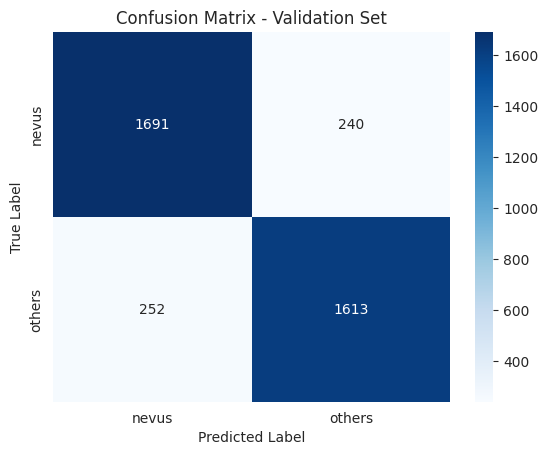

In [40]:
# Evaluate the model on the validation set
val_loss, val_acc = model_resnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_resnet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Access ground truth labels from the generator
val_true_classes = val_generator.y

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_true_classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (InceptionResNetV2)**

Reference: https://github.com/Defcon27/Skin-Cancer-Classification-using-Transfer-Learning/blob/master/Skin%20Cancer%20Prediction%20ResNet50.ipynb

In [7]:
# Load pre-trained InceptionResNetV2 model with weights trained on ImageNet data
inceptionresnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in inceptionresnet_model.layers:
    layer.trainable = True

# Build the custom model using InceptionResNetV2 as a feature extractor
x = inceptionresnet_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_inceptionresnet = Model(inputs=inceptionresnet_model.input, outputs=x)

# Compile the model
model_inceptionresnet.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_inceptionresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

    Callbacks

In [20]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_model_inceptionresnet150.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [21]:
# Train the model
history_inceptionresnet = model_inceptionresnet.fit(train_generator, epochs = 150, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/150
190/190 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.7912
Epoch 1: val_accuracy improved from -inf to 0.50839, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_inceptionresnet150.hdf5
190/190 [==============================] - 324s 1s/step - loss: 0.9676 - accuracy: 0.7912 - val_loss: 0.7278 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/150
190/190 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8245
Epoch 2: val_accuracy did not improve from 0.50839
190/190 [==============================] - 211s 1s/step - loss: 0.4242 - accuracy: 0.8245 - val_loss: 1.0245 - val_accuracy: 0.4916 - lr: 0.0010
Epoch 3/150
190/190 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8446
Epoch 3: val_accuracy did not improve from 0.50839
190/190 [==============================] - 212s 1s/step - loss: 0.3804 - accuracy: 0.8446 - val_loss: 0.7708 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 4/150
190/190 [========

In [8]:
# Load the saved weights
model_inceptionresnet.load_weights('/content/drive/MyDrive/Colab Notebooks/best_model_inceptionresnet150.hdf5')

48/48 [==============================] - 15s 313ms/step - loss: 0.6469 - accuracy: 0.8970
Ftest Loss: 0.6468709111213684, Ftest Accuracy: 0.8970056176185608


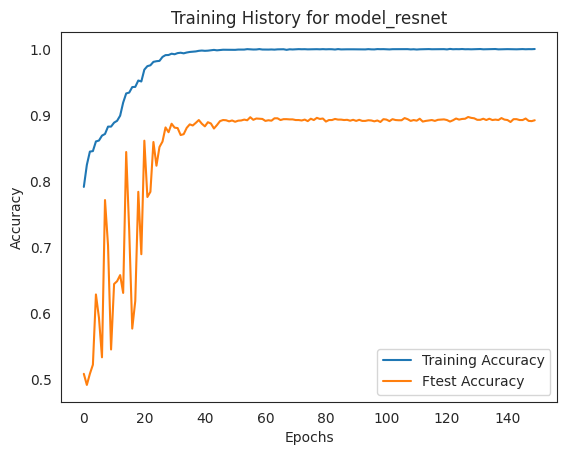

In [29]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_inceptionresnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_inceptionresnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_inceptionresnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_resnet')
plt.show()

**LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Data Preprocessing**

**Leveraging trained model for feature extraction and classification**

60/60 [==============================] - 22s 356ms/step - loss: 0.6184 - accuracy: 0.8999
Validation Loss: 0.6183608174324036, Validation Accuracy: 0.899894654750824
60/60 [==============================] - 21s 308ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1931
           1       0.89      0.91      0.90      1865

    accuracy                           0.90      3796
   macro avg       0.90      0.90      0.90      3796
weighted avg       0.90      0.90      0.90      3796



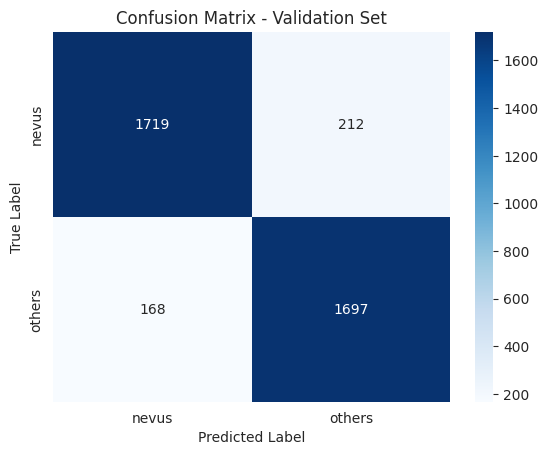

In [32]:
# Evaluate the model on the validation set
val_loss, val_acc = model_inceptionresnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_inceptionresnet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Access ground truth labels from the generator
val_true_classes = val_generator.y

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_true_classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (MobileNet)**

In [9]:
# Load pre-trained MobileNet model with weights trained on ImageNet data
mobilenet_model = MobileNet(weights = 'imagenet', input_shape = (224, 224, 3)) # include_top = False

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers[:-23]:
    layer.trainable = False

# Exclude the last 5 layers of the MobileNet model
x = mobilenet_model.layers[-6].output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)
x = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)
model_mobilenet = tensorflow.keras.models.Model(inputs=mobilenet_model.input, outputs=x)

# Compile the model
model_mobilenet.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.01), metrics = ["accuracy"])

# Display the model architecture
model_mobilenet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [24]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_model_mobilenet150.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [25]:
# Train the model
history_mobilenet = model_mobilenet.fit(train_generator, epochs = 150, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/150
190/190 [==============================] - ETA: 0s - loss: 2.8258 - accuracy: 0.5796
Epoch 1: val_accuracy improved from -inf to 0.50839, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_mobilenet150.hdf5
190/190 [==============================] - 132s 663ms/step - loss: 2.8258 - accuracy: 0.5796 - val_loss: 0.7915 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/150
190/190 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.6836
Epoch 2: val_accuracy did not improve from 0.50839
190/190 [==============================] - 123s 647ms/step - loss: 0.6067 - accuracy: 0.6836 - val_loss: 0.7286 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 3/150
190/190 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.6813
Epoch 3: val_accuracy did not improve from 0.50839

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
190/190 [==============================] - 122s 642ms/step - loss: 0.6031 - accuracy: 0.6813 - va

In [10]:
# Load the saved weights
model_mobilenet.load_weights('/content/drive/MyDrive/Colab Notebooks/best_model_mobilenet150.hdf5')

48/48 [==============================] - 4s 81ms/step - loss: 0.4547 - accuracy: 0.7930
Ftest Loss: 0.4546644389629364, Ftest Accuracy: 0.7930240035057068


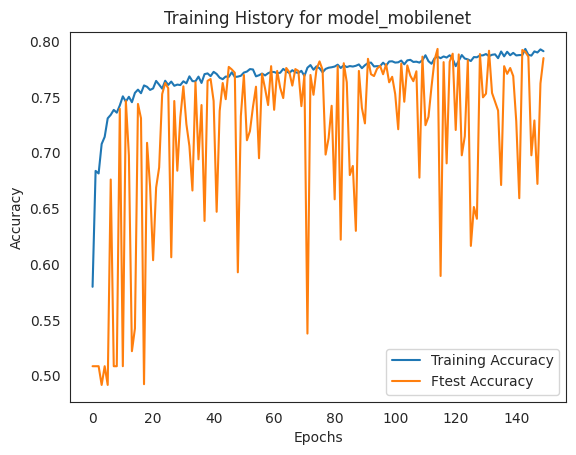

In [34]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_mobilenet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_mobilenet')
plt.show()

**LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Data Preprocessing**

**Leveraging trained model for feature extraction and classification**

60/60 [==============================] - 6s 95ms/step - loss: 0.4572 - accuracy: 0.7856
Validation Loss: 0.4572356641292572, Validation Accuracy: 0.7855637669563293
60/60 [==============================] - 6s 85ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      1931
           1       0.79      0.76      0.78      1865

    accuracy                           0.79      3796
   macro avg       0.79      0.79      0.79      3796
weighted avg       0.79      0.79      0.79      3796



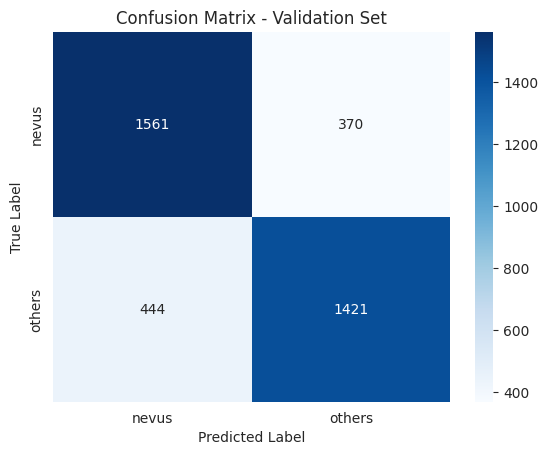

In [35]:
val_loss, val_acc = model_mobilenet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_mobilenet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
val_true_classes = val_generator.y  # Access the true classes from the generator
print("Classification Report on Validation Set:\n", classification_report(val_true_classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- ENSEMBLES**



**ResNet50 + MobileNet + InceptionResNet**

60/60 [==============================] - 12s 199ms/step
Classification Report on Validation Set - Ensemble:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      1931
           1       0.89      0.89      0.89      1865

    accuracy                           0.89      3796
   macro avg       0.89      0.89      0.89      3796
weighted avg       0.89      0.89      0.89      3796



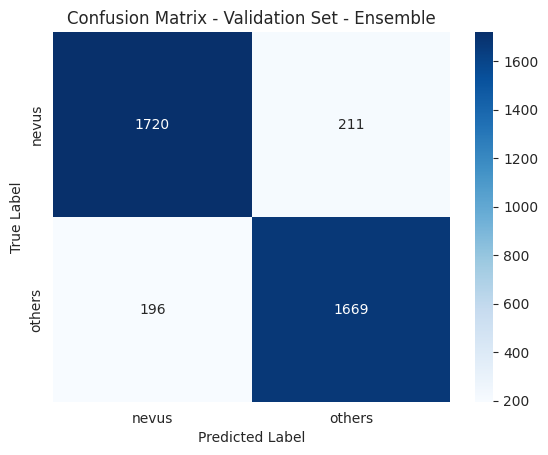

In [41]:
# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)
val_predictions_resnet = model_resnet.predict(val_generator)

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = (1/3) * (val_predictions_mobilenet + val_predictions_inceptionresnet + val_predictions_resnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

# Display classification report for the ensemble
print("Classification Report on Validation Set - Ensemble:\n", classification_report(val_generator.y, ensemble_pred_classes))

# Display confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(val_generator.y, ensemble_pred_classes)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set - Ensemble')
plt.show()

**ResNet50 + InceptionResNet**

60/60 [==============================] - 17s 286ms/step
Classification Report on Validation Set - Ensemble:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1931
           1       0.89      0.91      0.90      1865

    accuracy                           0.90      3796
   macro avg       0.90      0.90      0.90      3796
weighted avg       0.90      0.90      0.90      3796



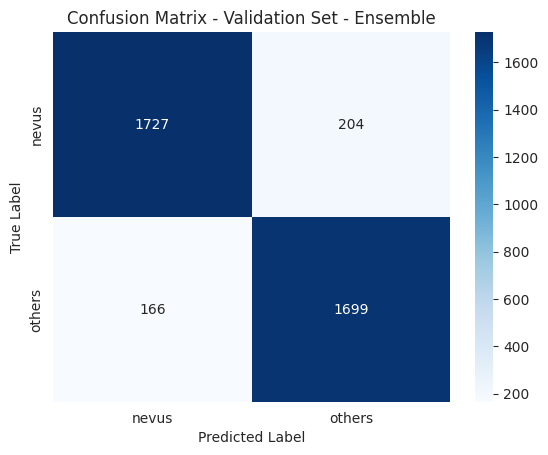

In [46]:
# Predictions on the validation set for both models
val_predictions_resnet = model_resnet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)

# Combine predictions
ensemble_predictions = 0.5 * (val_predictions_resnet + val_predictions_inceptionresnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

# Display classification report for the ensemble
print("Classification Report on Validation Set - Ensemble:\n", classification_report(val_generator.y, ensemble_pred_classes))

# Display confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(val_generator.y, ensemble_pred_classes)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set - Ensemble')
plt.show()

**MobileNet + InceptionResNet**

Best Model

60/60 [==============================] - 19s 310ms/step
Classification Report on Validation Set - Ensemble:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1931
           1       0.89      0.91      0.90      1865

    accuracy                           0.90      3796
   macro avg       0.90      0.90      0.90      3796
weighted avg       0.90      0.90      0.90      3796



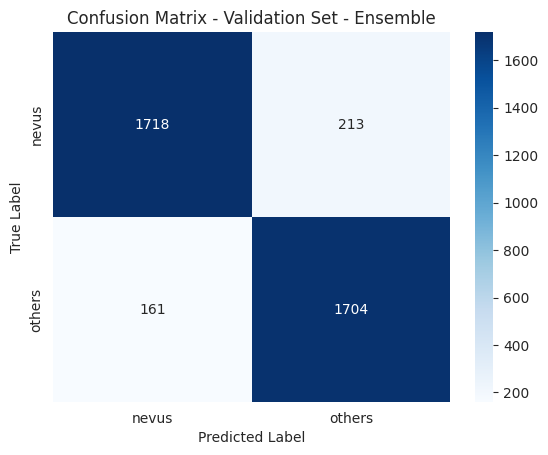

In [49]:
# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = 0.5 * (val_predictions_mobilenet + val_predictions_inceptionresnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

# Display classification report for the ensemble
print("Classification Report on Validation Set - Ensemble:\n", classification_report(val_generator.y, ensemble_pred_classes))

# Display confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(val_generator.y, ensemble_pred_classes)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set - Ensemble')
plt.show()

# **TESTING X**



    Time to use the best model to predict the TextX data and generate .csv for the challenge

In [15]:
# Initialize lists to store testX data
test_image_names = []
test_image_files = []
test_preprocessed_imgs = []

zip_file_path = '/content/drive/MyDrive/binarycollab.zip'

# Paths to the test directories within the zip file
test = "binarycollab/testX"

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    test_valid_images = [f for f in zip_ref.namelist() if f.startswith(test) and zip_ref.read(f)]

    for test_img in tqdm(test_valid_images, desc="testX"):
      test_img_content = zip_ref.read(test_img)

      if test_img_content:
        try:
            test_resized_images = np.array(load_and_resize_image(test_img_content))
            test_cropped_img = vignette_removal(test_resized_images, threshold=50)
            test_preprocessed_imgs.append(test_cropped_img)
            test_image_names.append(test_img)
            test_image_files.append(os.path.join(test, test_img))

        except Exception as e:
            print(f"Error processing image {test_img}: {e}")
      else:
        print(f"Empty content for image {test_img}")

testX: 100%|██████████| 6340/6340 [02:01<00:00, 52.11it/s]


In [16]:
# Create testX dataframe
test_data = {"test_img_name": test_image_names, "test_img_file": test_image_files, "test_preprocessed_images": test_preprocessed_imgs}; test_image_names.sort()
test_df = pd.DataFrame(test_data)
test_df.head()

,test_img_name,test_img_file,test_preprocessed_images
0,binarycollab/testX/xxx00001.jpg,binarycollab/testX/binarycollab/testX/xxx00001...,"[[[52, 50, 56], [62, 59, 67], [72, 69, 80], [7..."
1,binarycollab/testX/xxx00002.jpg,binarycollab/testX/binarycollab/testX/xxx00002...,"[[[232, 142, 153], [231, 139, 146], [230, 138,..."
2,binarycollab/testX/xxx00003.jpg,binarycollab/testX/binarycollab/testX/xxx00003...,"[[[89, 79, 80], [99, 89, 88], [107, 98, 95], [..."
3,binarycollab/testX/xxx00004.jpg,binarycollab/testX/binarycollab/testX/xxx00004...,"[[[96, 78, 81], [107, 87, 93], [114, 93, 99], ..."
4,binarycollab/testX/xxx00005.jpg,binarycollab/testX/binarycollab/testX/xxx00005...,"[[[118, 98, 97], [138, 119, 117], [153, 135, 1..."


In [18]:
# Test Data generator
ftest_datagen = ImageDataGenerator(rescale=1./255)

ftest_images = np.array([resize(test_image, target_shape) for test_image in test_df["test_preprocessed_images"].values])

# Flow validation images in batches using ftest_datagen generator
test_generator = ftest_datagen.flow(
    x=ftest_images,
    batch_size=batch_size,
    shuffle = False)

In [20]:
# Predictions on the validation set for both models
test_predictions_mobilenet = model_mobilenet.predict(test_generator)
test_predictions_inceptionresnet = model_inceptionresnet.predict(test_generator)

# Combine predictions
test_ensemble_predictions = 0.5 * (test_predictions_mobilenet + test_predictions_inceptionresnet)
test_ensemble_pred_classes = (test_ensemble_predictions > 0.5).astype(int)

100/100 [==============================] - 29s 292ms/step


In [24]:
# Flatten the predictions to ensure a 1-dimensional array
pred_classes  = test_ensemble_pred_classes.ravel()

# Create a DataFrame for the test results
test_results = pd.DataFrame({"image_name": test_df["test_img_name"], "image_label": pred_classes})
test_results.head()

,image_name,image_label
0,binarycollab/testX/xxx00001.jpg,0
1,binarycollab/testX/xxx00002.jpg,0
2,binarycollab/testX/xxx00003.jpg,1
3,binarycollab/testX/xxx00004.jpg,1
4,binarycollab/testX/xxx00005.jpg,1


In [25]:
# Save the test results to a CSV file
test_results.to_csv("/content/drive/MyDrive/Colab Notebooks/binary_test_results_DL.csv", index=False)